Shape: (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.00

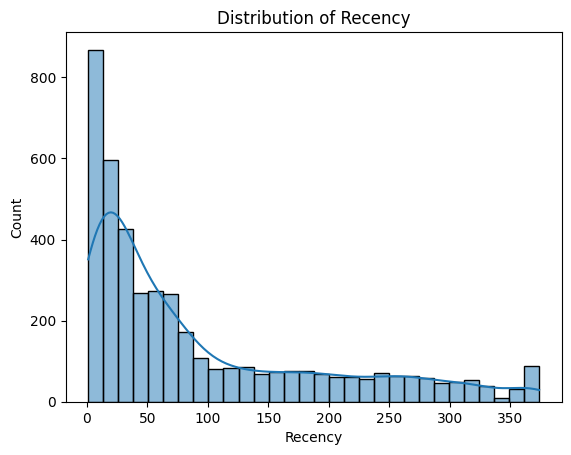


# Distribution of Frequency


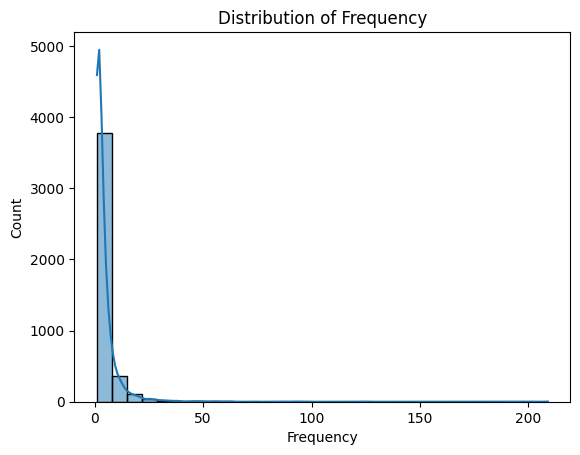


# Distribution of Monetary


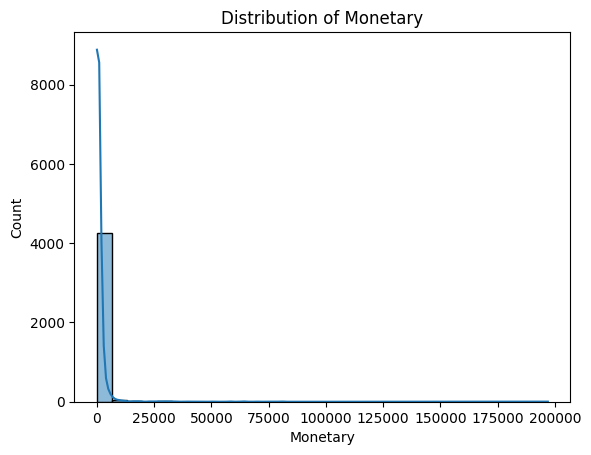


# Recency vs Frequency


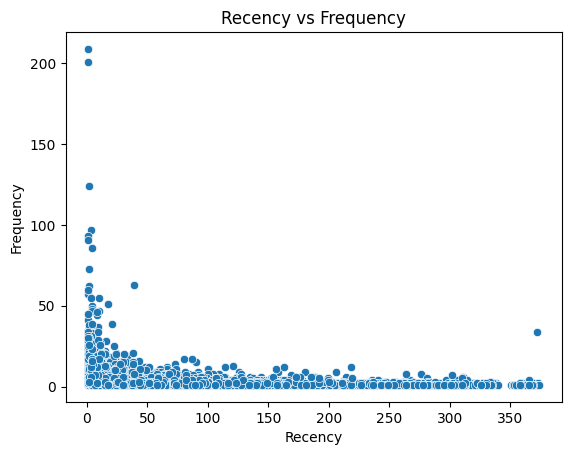


# Frequency vs Monetary


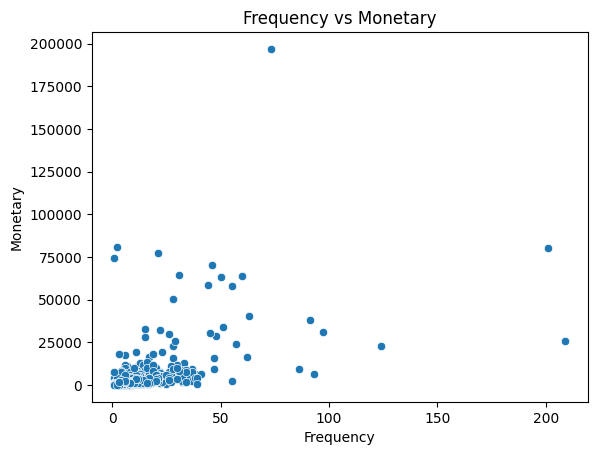


# Recency vs Monetary


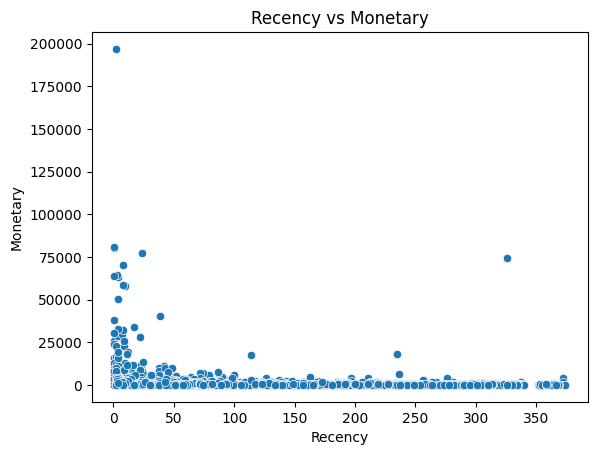


# Correlation Heatmap


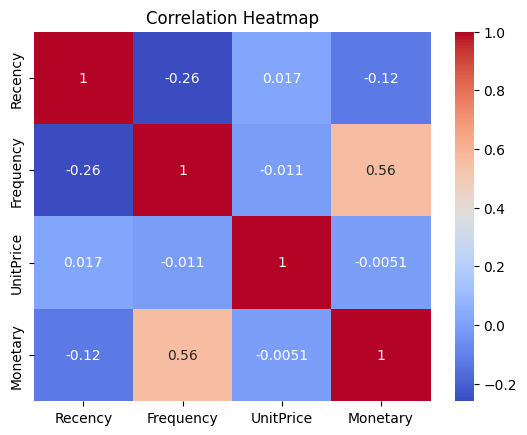

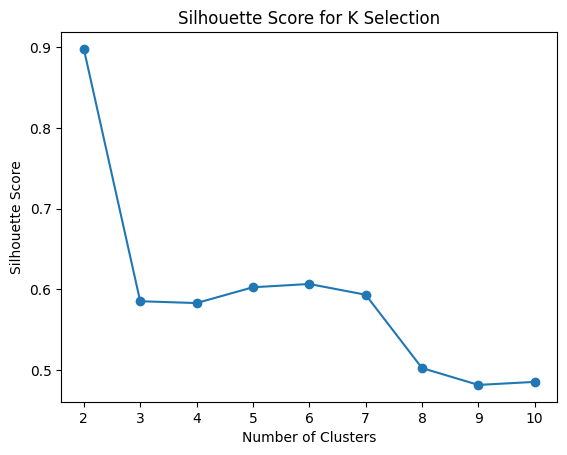

            Recency  Frequency      Monetary  Cluster
Cluster                                              
0         41.226906   4.703968   1120.187229     3226
1         19.500000  68.250000  51890.833333       24
2        246.432383   1.580497    283.999080     1087
3         85.000000   1.000000      1.000000        1

# Customer Segments


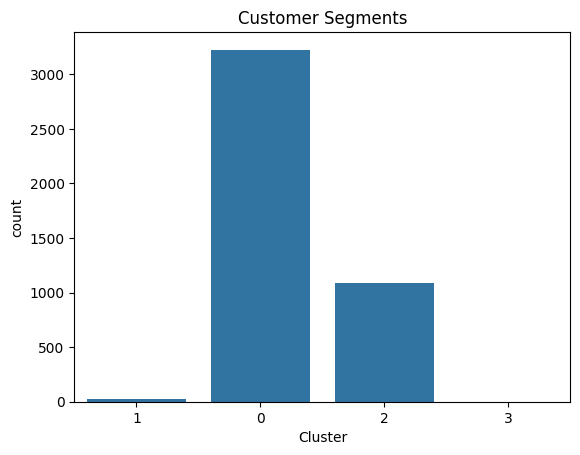


# Customer Segments (PCA)


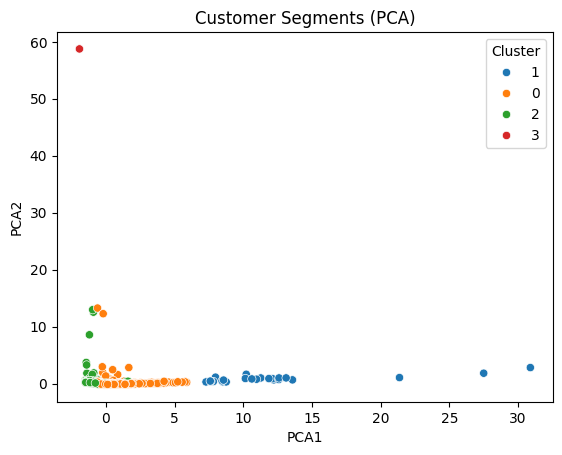

Top Products Recommended:
StockCode
23843     80995
23166     77916
84077     54415
22197     49183
85099B    46181
85123A    36782
84879     35362
21212     33693
23084     27202
22492     26076
Name: Quantity, dtype: int64

Project completed successfully. All steps executed without error.
Insights from customer segmentation and product trends can drive personalized marketing strategies.


In [14]:
# Shopper Spectrum: Customer Segmentation and Product Recommendations in E-Commerce

# ============================
# 1. Import Required Libraries
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings("ignore")

# ======================
# 2. Load and Inspect Data
# ======================
file_path = 'C:/Users/saini/Downloads/online_retail.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

print("Shape:", df.shape)
print(df.info())
print(df.describe())

# ===================
# 3. Data Cleaning
# ===================
df.dropna(subset=['CustomerID'], inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(int)

# ==============================
# 4. Feature Engineering (RFM)
# ==============================
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'UnitPrice': 'mean',
    'Quantity': 'sum'
})
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Quantity': 'Monetary'
}, inplace=True)
rfm = rfm[(rfm['Monetary'] > 0)]

# ==============================
# 5. Exploratory Data Analysis (UBM Charts)
# ==============================
def plot_chart(title, plot_func, *args, **kwargs):
    print(f"\n# {title}")
    plot_func(*args, **kwargs)
    plt.title(title)
    plt.show()

# Univariate
plot_chart("Distribution of Recency", sns.histplot, rfm['Recency'], bins=30, kde=True)
plot_chart("Distribution of Frequency", sns.histplot, rfm['Frequency'], bins=30, kde=True)
plot_chart("Distribution of Monetary", sns.histplot, rfm['Monetary'], bins=30, kde=True)

# Bivariate
plot_chart("Recency vs Frequency", sns.scatterplot, x='Recency', y='Frequency', data=rfm)
plot_chart("Frequency vs Monetary", sns.scatterplot, x='Frequency', y='Monetary', data=rfm)
plot_chart("Recency vs Monetary", sns.scatterplot, x='Recency', y='Monetary', data=rfm)

# Heatmap for correlation
plot_chart("Correlation Heatmap", sns.heatmap, rfm.corr(), annot=True, cmap='coolwarm')

# ==========================
# 6. Scaling the Features
# ==========================
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# ==========================
# 7. KMeans Clustering
# ==========================
scores = []
for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    scores.append(silhouette_score(rfm_scaled, model.labels_))

plt.plot(range(2, 11), scores, marker='o')
plt.title('Silhouette Score for K Selection')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# ==========================
# 8. Cluster Analysis
# ==========================
rfm['Cluster'] = rfm['Cluster'].astype(str)
r_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean', 'Frequency': 'mean', 'Monetary': 'mean', 'Cluster': 'count'
})
print(r_summary)

# Cluster Distribution
plot_chart("Customer Segments", sns.countplot, x='Cluster', data=rfm)

# PCA for 2D visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = pca_data[:, 0]
rfm['PCA2'] = pca_data[:, 1]
plot_chart("Customer Segments (PCA)", sns.scatterplot, x='PCA1', y='PCA2', hue='Cluster', data=rfm)

# ================================
# 9. Product Recommendation Logic
# ================================
popular_products = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)
print("Top Products Recommended:")
print(popular_products)

# ================================
# 10. Save Final Model (Optional)
# ================================
# import joblib
# joblib.dump(kmeans, 'customer_segmentation_model.pkl')

# ================================
# 11. Conclusion
# ================================
print("\nProject completed successfully.")
print("Insights from customer segmentation and product trends can drive personalized marketing strategies.")
